In [1]:
import math

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np

In [2]:
import gym
import tensorflow as tf

In [3]:
env = gym.make('Acrobot-v1')

[2016-10-16 13:06:26,029] Making new env: Acrobot-v1


In [3]:
env = gym.make('CartPole-v0')

[2016-10-16 13:26:33,666] Making new env: CartPole-v0


In [4]:
def PlayEpisode(env, policy, render=False, max_steps=None):
    observations, actions, rewards = [], [], []
    observation = None
    done = False
    steps = 0
    observation = env.reset()
    
    while not done and (max_steps is None or steps < max_steps):
        if render:
            env.render()
        
        observations.append(observation)
        action = policy(observation)
        actions.append(action)

        observation, reward, done, info = env.step(action)
        rewards.append(reward)  
        steps += 1

    if render:
        env.render(close=True)

    if isinstance(env.action_space, gym.spaces.Discrete):
        actions = np.reshape(actions, (len(actions), 1))
        
    return observations, actions, rewards, done

In [5]:
def RandomPolicy(env):
    def take_action(observation):
        return env.action_space.sample()
    
    return take_action

In [6]:
def EpsilonGreedy(env, epsilon, policy):
    def take_action(observation):
        if np.random.rand() < epsilon:
            return env.action_space.sample()
        else:
            return policy(observation)
    return take_action    

In [7]:
def Networks(env, states, hidden_num):
    """Maps states tensor to the pair of policy and value tensors."""
    with tf.device("/cpu:0"):
        with tf.variable_scope('common'):
            hidden = tf.contrib.layers.relu(states, hidden_num,
                                            weights_initializer=tf.truncated_normal_initializer(stddev=1.),
                                            biases_initializer=tf.constant_initializer(0.1))
        with tf.variable_scope('policy'):
            logits = tf.contrib.layers.linear(hidden, env.action_space.n)
        with tf.variable_scope('value'):
            value_out = tf.contrib.layers.linear(hidden, 1)
        return logits, value_out

-------

In [8]:
GAMMA = 0.99

In [9]:
RUN = 0

In [10]:
tf.reset_default_graph()

state = tf.placeholder(tf.float32, shape=[None, env.observation_space.shape[0]], name='states')
action = tf.placeholder(tf.int64, shape=[None, 1], name='actions')
discounted_values = tf.placeholder(tf.float32, shape=[None], name='discounted_values')
done_placeholder = tf.placeholder(tf.float32, shape=[None], name='done')

policy, value = Networks(env, state, 10)

In [11]:
with tf.device("/cpu:0"):
    optimizer = tf.train.AdamOptimizer(0.01)

In [12]:
advantage = tf.reshape(discounted_values, [-1, 1]) - value

cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(policy, tf.reshape(action, [-1]))
policy_loss = tf.reduce_mean(tf.mul(cross_entropy, tf.stop_gradient(advantage)))

policy_entropy = tf.reduce_mean(-tf.nn.softmax(policy) * tf.nn.log_softmax(policy))

value_loss = 0.5 * tf.reduce_mean(tf.square(advantage))

loss = policy_loss + 0.25 * value_loss - 0.01 * policy_entropy

grads = optimizer.compute_gradients(loss, tf.get_collection(tf.GraphKeys.VARIABLES))
grads = [(tf.clip_by_norm(g, 5), v) for g, v in grads]

for grad, var in grads:
    tf.histogram_summary(var.name, var)
    if grad is not None:
        tf.histogram_summary('{}/grad'.format(var.name), grad)

In [13]:
global_step = tf.Variable(0, name='global_step', trainable=False)
epsilon = 1.0 / (1.0 + tf.cast(global_step, tf.float32) / 3000.)
train_op = optimizer.apply_gradients(grads, global_step)

In [14]:
tf.histogram_summary("Predicted values", value)
tf.scalar_summary("Actor loss", policy_loss)
tf.scalar_summary("Critic loss", value_loss)
tf.scalar_summary("Policy entropy", policy_entropy)
tf.scalar_summary("Epsilon", epsilon)
tf.scalar_summary("Done", tf.reduce_mean(done_placeholder))

summary_op = tf.merge_all_summaries()

In [15]:
RUN += 1

# sess.close()
sess = tf.InteractiveSession()
sess.run(tf.initialize_all_variables())

writer = tf.train.SummaryWriter('/media/vertix/UHDD/tmp/tensorflow_logs/{}/{:02d}'.format(env.spec.id, RUN))

In [16]:
def TFPolicy(sess, policy_network):
    expression = tf.reshape(
        tf.multinomial(policy, 1), [])
    def take_action(observation):
        return sess.run(expression, {state: observation.reshape(1, env.observation_space.shape[0])})
    
    return take_action

In [17]:
def LearnEpisode(env, sess, policy, value):
    env.reset()
    done = False
    episode_sum = 0
    val_loss, pol_loss = [], []
    av_value = []
    eps, step = sess.run([epsilon, global_step])
    while not done:
        policy_func = EpsilonGreedy(env, eps, TFPolicy(sess, policy))
        ss, aa, rr, done = PlayEpisode(env, policy_func, max_steps=10)    

        if len(ss) == 1:
            continue

        R = np.zeros_like(rr)
        v_ = 0.
        if not done:
            v_ = sess.run(tf.reshape(value, []), 
                          feed_dict={state: ss[-1].reshape(1, env.observation_space.shape[0])})
        for i in reversed(xrange(len(rr))):
            v_ = rr[i] + GAMMA * v_
            R[i] = v_

        step, eps, _, summary = sess.run([
                global_step, epsilon, 
                train_op,
                summary_op if (step + 1) % 5 == 0 else tf.no_op()],
                {state: ss, action: aa, discounted_values: R, 
                 done_placeholder: [float(done)]})
        
        if summary is not None:
            writer.add_summary(summary, step)

        episode_sum += sum(rr)
    return episode_sum #, np.mean(val_loss), np.mean(pol_loss), np.mean(av_value)

In [18]:
def PlotValue(sess, value, values):
    grid = np.meshgrid(*values)
    shape = np.shape(grid[0])
    vinput = np.reshape(grid, (len(values), -1)).transpose()
    output = sess.run(value, feed_dict={state: vinput})
    image = output.reshape(shape).squeeze()
    extent = []
    for v in values:
        if not isinstance(v, (float, int)):
            extent.append(np.min(v, ))
            extent.append(np.max(v))
            
    plt.colorbar(plt.imshow(image, interpolation="nearest", extent=extent, aspect='auto'))

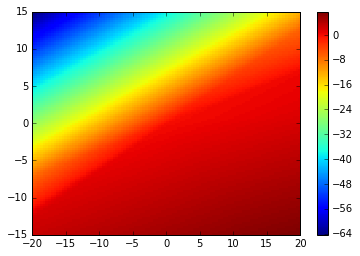

In [39]:
a = PlotValue(sess, value, [0, 0, np.linspace(-20., 20., 100), np.linspace(-15., 15., 100), 0., 0.])

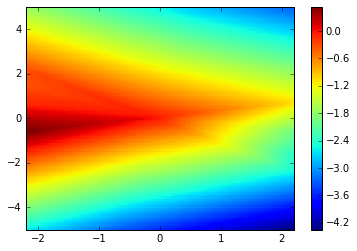

In [40]:
a = PlotValue(sess, value, [np.linspace(-2.2, 2.2, 100), np.linspace(-5., 5., 100), 0, 0, 0., 0.])

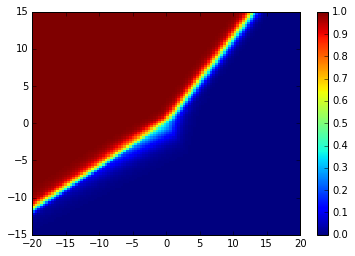

In [41]:
a = PlotValue(sess, tf.nn.softmax(policy)[:, 0],
              [0, 0, np.linspace(-20., 20., 100), np.linspace(-15., 15., 100), 0., 0.])

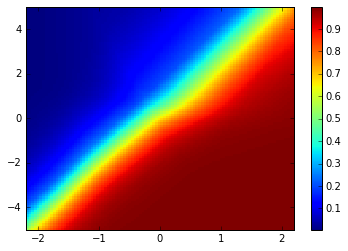

In [21]:
a = PlotValue(sess, tf.nn.softmax(policy)[:, 0],
              [np.linspace(-2.2, 2.2, 100), np.linspace(-5., 5., 100), 0, 0])

In [286]:
env.step(1)

(array([ 0.99847408,  0.05522233, -0.41032117, -0.91194108, -1.1073869 ,
         3.68590749]), -1.0, False, {})

In [285]:
PlayEpisode(env, RandomPolicy(env), True)

ArgumentError: argument 2: <type 'exceptions.TypeError'>: wrong type

In [22]:
env.reset()
print len(PlayEpisode(env, TFPolicy(sess, policy), True)[0])

62


In [19]:
# %%prun
for _ in range(10):
    print LearnEpisode(env, sess, policy, value)

400.0
70.0
109.0
400.0
260.0
70.0
218.0
80.0
180.0
49.0


In [ ]:
for _ in range(100000):
    LearnEpisode(env, sess, policy, value)
print LearnEpisode(env, sess, policy, value)
print LearnEpisode(env, sess, policy, value)
print LearnEpisode(env, sess, policy, value)
# print np.mean([LearnEpisode(env, sess, policy, value) for _ in range(100)])

In [47]:
env.reset()
PlayEpisode(env, TFPolicy(sess, policy), True)

OSError: [Errno 12] Cannot allocate memory